# Welcome!

In this session, we will learn how to implement some commonly used dimensionality reduction techniques. <br>
The following topics will be covered:
<ul>
    <li> PCA </li>
    <li> NMF </li>
    <li> tSNE </li>
    <li> UMAP </li>
</ul>
   

In [ ]:
# Importing packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='white', context='notebook', rc={'figure.figsize':(14,10)})

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.datasets import load_digits, fetch_olivetti_faces

# PCA - Prinicpal Component Analysis

PCA is statistical technique for reducing the dimensionality of the input data. It achieves this by creating new orthogonal variables that are linear combinations of existing ones while maximizing the variance explained by these variables.

In [ ]:
penguins = pd.read_csv(
    "https://raw.githubusercontent.com/allisonhorst/palmerpenguins/c19a904462482430170bfe2c718775ddb7dbb885/inst/extdata/penguins.csv")

penguins

In [ ]:
# Creating a pairwise scatterplots of the variables

sns.pairplot(data=penguins.drop('year', axis=1), hue='species')

In [ ]:
penguins = penguins.dropna() # Removing NaN values
penguins.species.value_counts()

In [ ]:
data = penguins[ # Choosing only numerical features
    [
        "bill_length_mm",
        "bill_depth_mm",
        "flipper_length_mm",
        "body_mass_g",
    ]
]
scaled_penguin_data = StandardScaler().fit_transform(data)
scaled_penguin_data

In [ ]:
pca = PCA() #Initializing the class
pca.fit(scaled_penguin_data) 

In [ ]:
pca.components_

In [ ]:
pca.components_@pca.components_.T

In [ ]:
pca.singular_values_

In [ ]:
sns.barplot(
    y = pca.explained_variance_ratio_,
            x = [f'Component {i}' for i in range(data.shape[1])]
)
plt.title('Explained variance of the components', size=18)
plt.xlabel('Components', size=15)
plt.ylabel('Proportion of Explained Variance', size=15)

In [ ]:
#Transforming data to lower dimensions
transformed_penguins_data = pca.transform(scaled_penguin_data)
transformed_penguins_data[:5]

In [ ]:
# It is the same as multiplying with the components
scaled_penguin_data[:5]@pca.components_.T

In [ ]:
# Creating a dataframe for plotting
transformed_penguins_df = pd.DataFrame(data = scaled_penguin_data, columns=[f'Component_{i}' for i in range(data.shape[1])])
transformed_penguins_df['species'] = penguins.species
transformed_penguins_df.sample(5)

In [ ]:
# Plotting in reduced dimensions

fig, ax = plt.subplots(figsize=(10,10))
sns.scatterplot(
    data = transformed_penguins_df,
    x='Component_0',
    y='Component_1',
    hue = 'species',
    s=200
)

# NMF - Non-negative Matrix Factorization

Non-negative Matrix factorization, as the name suggests, involves factorizing a non-negative matrix $X$ made up of $m$ features and $n$ samples into two non-negative matrices $W$ and $H$ with sizes $m \times k$ and $ k \times m$ respectively. Here, $W$ represents the grouped subfeatures in the data and $H$ represents the information on the combination of these subfeatures in the particular samples

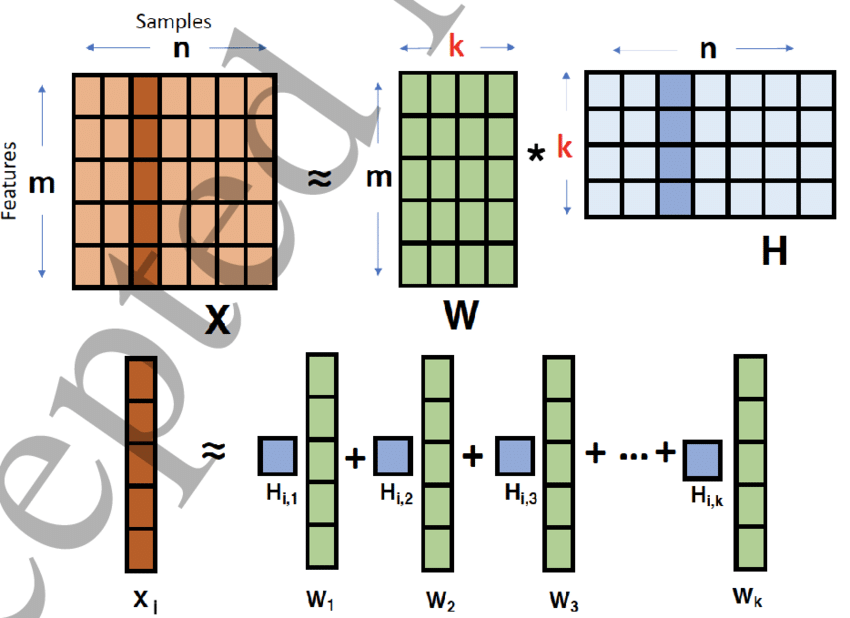
Source: <a href='https://www.researchgate.net/figure/An-illustration-of-the-non-negative-matrix-factorization-of-two-low-rank-matrices-W-and-H_fig1_342762752'>ResearchGate</a>

In [ ]:
from sklearn.decomposition import NMF

In [ ]:
print(fetch_olivetti_faces().DESCR)

In [ ]:
faces, name = fetch_olivetti_faces(return_X_y=True, shuffle=True, random_state=0)
n_samples, n_features = faces.shape

In [ ]:
# Visualizing the data
plt.figure(figsize=(5,5))
plt.imshow(faces[1].reshape(64,64), cmap=plt.cm.gray, interpolation='nearest')
plt.axis('off')

In [ ]:

nmf = NMF(n_components=25, max_iter=1500, tol=5e-5, random_state=2)
nmf.fit(faces)

In [ ]:
nmf.components_.shape

In [ ]:
# Visualizing the components

fig, axes = plt.subplots(5,5, figsize=(15,15), facecolor='white', constrained_layout=True)

fig.suptitle('Components of NMF', size=18)

for ax, image in zip(axes.flatten(), nmf.components_):
    im = ax.imshow(
        image.reshape(64,64),
        cmap=plt.cm.gray,
        interpolation = 'nearest',
    )
    ax.axis('off')
fig.colorbar(im, ax=axes, orientation="horizontal")

In [ ]:
index = 3
weight = nmf.transform(faces[index].reshape(1,-1))
print('Weight vector:',)
display(weight)
reconstructed_image = weight@nmf.components_

fig, ax = plt.subplots(1, 2, constrained_layout=True, facecolor='white')

ax[0].imshow(faces[index].reshape(64,64), cmap=plt.cm.gray, interpolation='nearest')
ax[0].set_title('Original image', size=14)
ax[0].axis('off')

ax[1].imshow(reconstructed_image.reshape(64,64), cmap=plt.cm.gray, interpolation='nearest')
ax[1].set_title('Reconstructed image', size=14)
ax[1].axis('off');

In [ ]:
# Create new face 
weight_vector = np.random.uniform(0,1, 25)

reconstructed_image = weight_vector@nmf.components_

plt.figure(figsize=(5,5))
plt.imshow(reconstructed_image.reshape(64,64), cmap=plt.cm.gray)
plt.axis('off')
plt.title('Generated Figure')

## Further Reading:

<ul>
<li>Lee, D., Seung, H. Learning the parts of objects by non-negative matrix factorization. Nature 401, 788–791 (1999). <a href='https://doi.org/10.1038/44565'>https://doi.org/10.1038/44565<a/a></li>

<li> <a href='https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html#sklearn.decomposition.NMF'>NMF-Scikit-Learn</a></li>

# t-SNE - t-Distributed Stochastic Neighbor Embedding

t-SNE is a statistical technique for visulaizing high-dimensional data in a lower dimension. It is a non-linear dimensionality reduction technique. The goal is to represent similar points closer to one another and dissimilar points far from each other. It achieves this by the following steps:

<ol>
    <li> Construct a probability distribution over pairs of samples based on their similarity </li>
    <li> Define a similar probability distribution in low dimension (usually 2 or 3) and minimize the Kullback-Leibler Divergence between the two distributions </li>
    </ol>
The commonly used similarity metric is the Euclidean distance. One important parameter that can be adjusted in tSNE is perplexity. Perplexity, to put simply, is a guess about the number of 'similar' neighbors there are to a given point.

In [ ]:
digits = load_digits()
print(digits.DESCR)

In [ ]:
fig, axes = plt.subplots(8,8)

for i, ax in enumerate(axes.flatten()):
    ax.imshow(digits.images[i], cmap='gray_r')

plt.setp(axes.flatten(), xticks=[], yticks=[], frame_on=False);

In [ ]:
#Image matrix
digits.images[0]

In [ ]:
# Flattened image
digits.data[0]

In [ ]:
scaled_digit_data = StandardScaler().fit_transform(digits.data)
pca = PCA().fit(scaled_digit_data)

sns.barplot(y=np.cumsum(pca.explained_variance_ratio_),
            x = [i for i in range(64)],
           color = 'salmon')
plt.title('Explained Variance - Digits Data', size=18)
plt.axhline(y=0.9, c='k', ls='--')
plt.xlabel('Components', size=14)
plt.ylabel('Cumulative Explained Variance', size=14)

In [ ]:
from sklearn.manifold import TSNE

In [ ]:
perplexity = 50
tsne = TSNE(
        n_components=2,
        perplexity = perplexity,
        n_iter=500,
        n_iter_without_progress=150,
        n_jobs=2,
        random_state=0,
    )


tsne_transform = tsne.fit_transform(scaled_digit_data)

In [ ]:
digits_tsne = pd.DataFrame(data = tsne_transform, columns=[f'Component_{i}' for i in range(2)])
digits_tsne['number'] = digits.target

In [ ]:
cmap = sns.color_palette('Spectral', n_colors=10)
fig, ax = plt.subplots(figsize=(10,10))
sns.scatterplot(
    data=digits_tsne,
    x='Component_0',
    y='Component_1',
    hue='number',
    palette=cmap
)
plt.title('tSNE on the handwritten digits dataset', size=18)

## Further Reading

<ul>
  <li>Van der Maaten, L., & Hinton, G. (2008). Visualizing data using t-SNE. Journal of machine learning research, 9(11).</li>
    <li> <a href='https://lvdmaaten.github.io/tsne/'>tSNE - Inventor Website</a></li>
    <li><a href='https://distill.pub/2016/misread-tsne/'>Common Pitfalls and Precautions</a></li>
</ul>

# UMAP - Uniform Manifold Approximation and Projection

UMAP is a powerful visualization technique for representing high-dimensional data. Although the mathematics behind UMAP is advanced and behind the scope of this class, it can be understood this way: The points are modelled in the high-dimension as a weighted graph where similar objects have an higher edge weight. Then, a low dimensional analogue is created and optimized to be as similar to the high-dimensional graph as possible.<br>

UMAP has two advantages over tSNE: 
<ul>
    <li> It is faster</li>
    <li> It better preserves global structure </li>
</ul>

UMAP has two important parameters:
<ul>
    <li> <code>n_neighbors</code> - which controls the balance between global and local structure</li>
    <li> <code>min_dist</code> - The minimum distance between two points in the lower representation </li>
</ul>

The required packages can be installed as follows:<br>
<center><code>pip install umap-learn</code></center>
<center><code>pip install umap-learn[plot]</code></center>

In [ ]:
from umap import UMAP
import umap.plot

In [ ]:

n_neighbors = 60
min_dist = 0.01
reducer = UMAP(
    n_neighbors=n_neighbors,
    min_dist=min_dist,
    random_state=42
)
reducer.fit(scaled_digit_data)

In [ ]:
digits_umap = reducer.transform(scaled_digit_data)

umap_df = pd.DataFrame(data = digits_umap, columns=[f'Component_{i}' for i in range(2)])
umap_df['number'] = digits.target

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
sns.scatterplot(
    data=umap_df,
    x='Component_0',
    y='Component_1',
    hue='number',
    palette=cmap
)

In [ ]:
umap.plot.points(reducer, labels=digits.target)

## Further Reading:
<ul>
    <li> The original documentation with the introduction to the working of UMAP: <a href='https://umap-learn.readthedocs.io/en/latest/how_umap_works.html'>link</a></li>
    <li> A visual explanation of UMAP: <a href='https://pair-code.github.io/understanding-umap/'> link</a></li>
</ul>